In [8]:
#!/usr/bin/env python3
# coding: utf-8
""" Usage:
    python3 thai-student-stat.py directory
"""

' Usage:\n    python3 thai-student-stat.py directory\n'

In [26]:
import glob
import tgt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import edit_distance

VOWELS=['i', 'y', 'u', 'ɨ', 'ɤ', 'e', 'ɛ', 'ə', 'o',  'ɔ',  'a', 'ɚ']
CONSONS= ['p', 'pʰ', 't', 'tʰ', 'k', 'kʰ', 'ts', 'tsʰ', 'tʂ', 'tʂʰ', 'tɕ', 'tɕʰ', 'f', 'ɕ', 'x', 's', 
          'ʂ', 'ʐ', 'm', 'n', 'ŋ', 'l', 'ɥ', 'j', 'w']
LABELS = VOWELS+CONSONS
#print(CONSONS)

In [27]:
def contains_chinese(check_str):
    """
    判断字符串中是否包含中文
    :param check_str: {str} 需要检测的字符串
    :return: {bool} 包含返回True， 不包含返回False
    """
    for ch in check_str:
        if u'\u4e00' <= ch <= u'\u9fff':
            return True
    return False

def all_chinese(check_str):
    for ch in check_str:
        if not (u'\u4e00' <= ch <= u'\u9fff'):
            return False
    return True

In [28]:
def list_gen_and_plot(tplist, splist, TEMPL):
    vtplist = []
    vsplist = []
    for i in range(len(tplist)):
        if tplist[i] in TEMPL:
            vtplist.append(tplist[i])
            vsplist.append(splist[i])
    mat = confusion_matrix(vtplist, vsplist, labels=TEMPL)
    df_cm = pd.DataFrame(mat, index = TEMPL, columns = TEMPL)
    plt.figure(figsize = (20,15))
    sn.heatmap(df_cm, annot=True,cmap="OrRd",fmt="d")
    plt.xlabel("Thai children")
    plt.ylabel("Taiwan Instructor")
    plt.show()


In [29]:
def fdistance(S1,S2):
    a = len(S1)
    b = len(S2)
    fdn = {} # Global dict

    for x in range(a+1):
        for y in range(b+1):
            fdn[x,y] = 0
    
    for x in range(a+1):
        fdn[x,0] = x
    for y in range(b+1):
        fdn[0,y] = y

    print(fdn)
    for x in range(1,a+1):
        for y in range(1,b+1):
            if S1[x-1] == S2[y-1]: 
                c = 0 
            else:
                c = 1
            minc = min(fdn[x,y-1]+1, fdn[x-1,y]+1, fdn[x-1,y-1]+c)

    return fdn[x,y]

In [30]:
def substCost(x,y):
    if x == y: 
        return 0
    else: 
        return 1

def levenshtein(target, source):
    i = len(target)
    j = len(source)
    if i == 0:  
        return j
    elif j == 0: 
        return i

    return(min(levenshtein(target[:i-1],source)+1,
               levenshtein(target, source[:j-1])+1,
               levenshtein(target[:i-1], source[:j-1])+substCost(source[j-1],target[i-1])))

In [31]:
def opprint(t, s, op):
    for tag, i1, i2, j1, j2 in op:
        print('{:7}   a[{}:{}] --> b[{}:{}] {!r:>8} --> {!r}'.format(tag, i1, i2, j1, j2, t[i1:i2], s[j1:j2]))

In [32]:
def stat_main(txtgridr):
    #print(txtgridr)
    txtlist = glob.glob(txtgridr+"/*.14")
    print("File list", txtlist)
    tplist = []
    splist = []
    tcvlist=[]
    scvlist=[]
    t6list=[]
    s6list=[]
    for txtgridf in txtlist:
        tg = tgt.io.read_textgrid(txtgridf, encoding='utf-8', include_empty_intervals=True)
        t1=tg.get_tier_by_name('IU/teacher')
        t4=tg.get_tier_by_name('IU/phone')
        t5=tg.get_tier_by_name('IU/syllable')
        t6=tg.get_tier_by_name('IU/tone')
        t7=tg.get_tier_by_name('IU/student-7')
        t10=tg.get_tier_by_name('IU/student-10')
        t11=tg.get_tier_by_name('EU/syllable')
        t12=tg.get_tier_by_name('EU/tone')
        
        for i in t1:
            t = i.text.replace(' ','').replace('*','').replace('^','')
            if all_chinese(t):
                for j in t7:
                    jtext = j.text.replace(' ','').replace('*','').replace('^','')

                    if i.text == jtext:
                        #print(jtext)
                        tap = t4.get_annotations_between_timepoints(i.start_time, i.end_time, left_overlap=True, right_overlap=True)
                        sap = t10.get_annotations_between_timepoints(j.start_time, j.end_time, left_overlap=True, right_overlap=True)
                        tacv = t5.get_annotations_between_timepoints(i.start_time, i.end_time, left_overlap=True, right_overlap=True)
                        sacv = t11.get_annotations_between_timepoints(j.start_time, j.end_time, left_overlap=True, right_overlap=True)
                        ta6 = t6.get_annotations_between_timepoints(i.start_time, i.end_time, left_overlap=True, right_overlap=True)
                        sa6 = t12.get_annotations_between_timepoints(j.start_time, j.end_time, left_overlap=True, right_overlap=True)

                        ntl=[]
                        stl=[]
                        if (len(tap) != len(sap)):
                            print(jtext, end=" ")
                            for iap in tap:
                                #print(iap.text, end="")
                                if iap.text != "":
                                    ntl.append(iap.text)
                            #print('->', end="")
                            for iap in sap:
                                #print(iap.text, end="")
                                if iap.text != "":
                                    stl.append(iap.text)
                            dist=edit_distance.SequenceMatcher(a=ntl, b=stl)
                            #c = fdistance(ntl,stl)
                            #c = levenshtein(stl, ntl)
                            #print(ntl, stl)
                            #op = dist.get_opcodes()
                            mop = dist.matches()
                            #opprint(ntl,stl, op)
                            print(ntl, stl, mop)
                            #print(ntl, stl, c)
                        else:
                            for tt, ss in zip(tap, sap):
                                try:
                                    #print('[',t.text,'][', s.text, ']')
                                    tstr = tt.text.replace(' ','')
                                    sstr = ss.text.replace(' ','')
                                    tplist.append(tstr)
                                    splist.append(sstr)
                                except:
                                    print('Exception')
                        
#                         # CVSN
#                         print(tacv, sacv)
#                         if (len(tacv.text) != len(sacv.text)):
#                             print(len(tacv.text), len(sacv.text), tacv.text, sacv.text)
#                         else:
#                             tlacv = list(tacv)
#                             slacv = list(sacv)
#                             print(tacv, sacv)
#                             for t, s in zip(tlacv, slacv):
#                                 try:
                                    
#                                     #print('[',t.text,'][', s.text, ']')
#                                     tstr = t.text.replace(' ','')
#                                     sstr = s.text.replace(' ','')
#                                     tcvlist.append(tstr)
#                                     scvlist.append(sstr)
#                                 except:
#                                     print('Exception') 
                                
    #print(len(tplist), len(splist))
    list_gen_and_plot(tplist, splist, VOWELS)
    list_gen_and_plot(tplist, splist, CONSONS)
    #print(tcvlist, scvlist)
    #list_gen_and_plot(tcvlist, scvlist, ["C","V","G","N"])

In [33]:
def stat_main(txtgridr):
    #print(txtgridr)
    txtlist = glob.glob(txtgridr+"/*.14")
    print("File list", txtlist)
    tplist = []
    splist = []
    tcvlist=[]
    scvlist=[]
    t6list=[]
    s6list=[]
    for txtgridf in txtlist:
        tg = tgt.io.read_textgrid(txtgridf, encoding='utf-8', include_empty_intervals=True)
        t1=tg.get_tier_by_name('IU/teacher')
        t4=tg.get_tier_by_name('IU/phone')
        t5=tg.get_tier_by_name('IU/syllable')
        t6=tg.get_tier_by_name('IU/tone')
        t7=tg.get_tier_by_name('IU/student-7')
        t10=tg.get_tier_by_name('IU/student-10')
        t11=tg.get_tier_by_name('EU/syllable')
        t12=tg.get_tier_by_name('EU/tone')
        
        for i in t1:
            t = i.text.replace(' ','').replace('*','').replace('^','')
            if all_chinese(t):
                for j in t7:
                    jtext = j.text.replace(' ','').replace('*','').replace('^','')

                    if i.text == jtext:
                        #print(jtext)
                        tap = t4.get_annotations_between_timepoints(i.start_time, i.end_time, left_overlap=True, right_overlap=True)
                        sap = t10.get_annotations_between_timepoints(j.start_time, j.end_time, left_overlap=True, right_overlap=True)
                        tacv = t5.get_annotations_between_timepoints(i.start_time, i.end_time, left_overlap=True, right_overlap=True)
                        sacv = t11.get_annotations_between_timepoints(j.start_time, j.end_time, left_overlap=True, right_overlap=True)
                        ta6 = t6.get_annotations_between_timepoints(i.start_time, i.end_time, left_overlap=True, right_overlap=True)
                        sa6 = t12.get_annotations_between_timepoints(j.start_time, j.end_time, left_overlap=True, right_overlap=True)

                        ntl=[]
                        stl=[]
                        if (len(tap) != len(sap)):
                            print(jtext, end=" ")
                            for iap in tap:
                                #print(iap.text, end="")
                                if iap.text != "":
                                    ntl.append(iap.text)
                            #print('->', end="")
                            for iap in sap:
                                #print(iap.text, end="")
                                if iap.text != "":
                                    stl.append(iap.text)
                            dist=edit_distance.SequenceMatcher(a=ntl, b=stl)
                            #c = fdistance(ntl,stl)
                            #c = levenshtein(stl, ntl)
                            #print(ntl, stl)
                            #op = dist.get_opcodes()
                            mop = dist.matches()
                            #opprint(ntl,stl, op)
                            print(ntl, stl, mop)
                            #print(ntl, stl, c)
                        else:
                            for tt, ss in zip(tap, sap):
                                try:
                                    #print('[',t.text,'][', s.text, ']')
                                    tstr = tt.text.replace(' ','')
                                    sstr = ss.text.replace(' ','')
                                    tplist.append(tstr)
                                    splist.append(sstr)
                                except:
                                    print('Exception')
                        
#                         # CVSN
#                         print(tacv, sacv)
#                         if (len(tacv.text) != len(sacv.text)):
#                             print(len(tacv.text), len(sacv.text), tacv.text, sacv.text)
#                         else:
#                             tlacv = list(tacv)
#                             slacv = list(sacv)
#                             print(tacv, sacv)
#                             for t, s in zip(tlacv, slacv):
#                                 try:
                                    
#                                     #print('[',t.text,'][', s.text, ']')
#                                     tstr = t.text.replace(' ','')
#                                     sstr = s.text.replace(' ','')
#                                     tcvlist.append(tstr)
#                                     scvlist.append(sstr)
#                                 except:
#                                     print('Exception') 
                                
    #print(len(tplist), len(splist))
    list_gen_and_plot(tplist, splist, VOWELS)
    list_gen_and_plot(tplist, splist, CONSONS)
    #print(tcvlist, scvlist)
    #list_gen_and_plot(tcvlist, scvlist, ["C","V","G","N"])

File list ['data\\ZOOM0001_LR.TextGrid.14', 'data\\ZOOM0002_LR.TextGrid.14', 'data\\ZOOM0003_LR.TextGrid.14', 'data\\ZOOM0004_LR.TextGrid.14', 'data\\ZOOM0004_做實驗.TextGrid.14', 'data\\ZOOM0005_LR-1.TextGrid.14', 'data\\ZOOM0005_LR.TextGrid.14', 'data\\ZOOM0007_Jinghuang.TextGrid.14', 'data\\ZOOM0007_LR.TextGrid.14', 'data\\ZOOM0007_LR_TextGrid.14', 'data\\ZOOM0008_test_one_by_one.TextGrid.14', 'data\\ZOOM0009_LR.TextGrid.14']
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ɕ', 'j', 'a', 'ŋ'] 4
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'j', 'a', 'w', 'ʂ', 'a', 'ŋ'] 5
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'w', 'o', 'ŋ', 'u'] 3
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'w', 'o', 'ŋ', 'u'] 3
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'w', 'o', 'ŋ', 'u'] 3
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'w', 'o', 'ŋ', 'u'] 3
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'w', 'o', 'ŋ', 'u'] 3
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'w', 'o', 'ŋ', 'u'] 3
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'w', 'o', 'ŋ', 'u'] 3
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'w', 'o', 'ŋ', 'u'] 

晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'i', 'a', 'w', 'ts', 'w', 'e', 'j', 'tɕ', 'i', 'a', 'w'] 12
晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['b', 'w', 'ə', 'n', 'tsʰ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'ts', 'j', 'a', 'w'] 11
晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['w', 'a', 'n', 'tsʰ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'j', 'a', 'w'] 13
晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['w', 'a', 'n', 'tsʰ', 'a', 'ŋ', 'j', 'a', 'w', 'tsʰ', 'w', 'e', 'j', 'ɕ', 'j', 'a', 'w'] 11
晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'i', 'a', 'w', 'ts', 'w', 'e', 'j', 'tɕ', 'i', 'a', 'w'] 12
晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['b', 'w

晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['b', 'w', 'ə', 'n', 'tsʰ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'ts', 'j', 'a', 'w'] 11
晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['w', 'a', 'n', 'tsʰ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'j', 'a', 'w'] 13
晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['w', 'a', 'n', 'tsʰ', 'a', 'ŋ', 'j', 'a', 'w', 'tsʰ', 'w', 'e', 'j', 'ɕ', 'j', 'a', 'w'] 11
晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'i', 'a', 'w', 'ts', 'w', 'e', 'j', 'tɕ', 'i', 'a', 'w'] 12
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'j', 'a', 'w', 'ʂ', 'a', 'ŋ'] 5
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕʰ', 'j', 'a', 'w', 'ts', 'a', 'n'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'j', 'a', 'ŋ', 'tɕʰ', 'j', 'a', 'ŋ'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['ts', 'j

下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'a', 'u'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'a', 'u'] 3
我下午回家 ['w', 'ɔ', 'ɕ', 'j', 'a', 'u', 'x', 'w', 'e', 'j', 'tɕ', 'j', 'a'] ['w', 'ɔ', 'tɕʰ', 'i', 'a', 'u', 'w', 'e', 'j', 'tɕ', 'j', 'a'] 10
我 ['w', 'ɔ'] ['ɔ'] 1
我 ['w', 'ɔ'] ['ɔ'] 1
我 ['w', 'ɔ'] ['ɔ'] 1
我 ['w', 'ɔ'] ['ɔ'] 1
我下午回家 ['w', 'ɔ', 'ɕ', 'j', 'a', 'u', 'x', 'w', 'e', 'j', 'tɕ', 'j', 'a'] ['w', 'ɔ', 'tɕʰ', 'i', 'a', 'u', 'w', 'e', 'j', 'tɕ', 'j', 'a'] 10
我 ['w', 'ɔ'] ['ɔ'] 1
我 ['w', 'ɔ'] ['ɔ'] 1
我 ['w', 'ɔ'] ['ɔ'] 1
我 ['w', 'ɔ'] ['ɔ'] 1
我 ['w', 'ɔ'] ['ɔ'] 1
我 ['w', 'ɔ'] ['ɔ'] 1
我 ['w', 'ɔ'] ['ɔ'] 1
我 ['w', 'ɔ'] ['ɔ'] 1
睡覺 ['ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['ʂ', 'w', 'e', 'j', 'tɕ', 'i', 'a', 'w'] 5
睡覺 ['ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['ts', 'w', 'e', 'j', 'tɕ', 'j', 'a', 'w'] 4
睡覺 ['ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['ʂ', 'w', 'e', 'i', 'tɕ', 'j', 'a', 'w'] 4
睡覺 ['ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['ʂ', 'w', 'e', 'j', 'tɕ', 'j', 'a', 'w'] 5
睡覺 ['ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['ts'

晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'ʂ', 'a', 'ŋ'] 5
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'ʂ', 'a', 'n'] 4
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'ʂ', 'a', 'n'] 4
早上好冷 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'ə', 'ŋ'] ['t', 'j', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'ə', 'ŋ'] 11
中午好冷 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'l', 'ə', 'ŋ'] ['t', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'l', 'ə'] 8
早上好冷 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'ə', 'ŋ'] ['t', 'j', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'ə', 'ŋ'] 11
早上好涼快 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'kʰ', 'w', 'a', 'j'] ['ts', 'o', 'ʂ', 'a', 'n', 'x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'k', 'w', 'a', 'j'] 13
早上好涼快 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'kʰ', 'w', 'a', 'j'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'n', 'x', 'a', 'w', 'l', 'i', 'n', 'k', 'w', 'a', 'j'] 11
早上好涼快 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'kʰ', 

好涼快 ['x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'kʰ', 'w', 'a', 'j'] ['x', 'a', 'w', 'y', 'n', 'kʰ', 'w', 'a', 'j'] 7
好涼快 ['x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'kʰ', 'w', 'a', 'j'] ['x', 'a', 'w', 'l', 'ə', 'ŋ', 'kʰ', 'w', 'a', 'j'] 9
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'j', 'a', 'w', 'ʂ', 'a', 'ŋ'] 5
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕʰ', 'j', 'a', 'w', 'ts', 'a', 'n'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'j', 'a', 'ŋ', 'tɕʰ', 'j', 'a', 'ŋ'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['ts', 'j', 'a', 'w', 'ɕ', 'j', 'a', 'ŋ'] 5
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'j', 'a', 'w', 'ʂ', 'a', 'ŋ'] 5
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕʰ', 'j', 'a', 'w', 'ts', 'a', 'n'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'j', 'a', 'ŋ', 'tɕʰ', 'j', 'a', 'ŋ'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['ts', 'j', 'a', 'w', 'ɕ', 'j', 'a', 'ŋ'] 5
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'a', 'u'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'a', 'u'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'a', 'u'] 2
下午 ['ɕ', 'j', 'a', 'u']

晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'j', 'a', 'ŋ'] 5
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ɕ', 'a'] 4
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'tɕʰ', 'j', 'a', 'ŋ'] 5
幾點 ['tɕ', 'i', 't', 'j', 'ɛ', 'n'] ['tɕ', 'i', 't', 'i', 'ɛ̃'] 3
七點 ['tɕʰ', 'i', 't', 'j', 'ɛ', 'n'] ['tɕʰ', 'ɨ', 't', 'j', 'ɛ̃'] 3
七點 ['tɕʰ', 'i', 't', 'j', 'ɛ', 'n'] ['tɕʰ', 'ɨ', 't', 'j', 'ɛ̃'] 3
上 ['ʂ', 'a', 'ŋ'] ['x', 'j', 'a', 'ŋ'] 2
幾點 ['tɕ', 'i', 't', 'j', 'ɛ', 'n'] ['tɕ', 'i', 't', 'i', 'ɛ̃'] 3
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'j', 'a', 'ŋ'] 5
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'ɕ', 'a'] 3
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'j', 'a', 'ŋ'] 5
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ɕ', 'a'] 4
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'tɕʰ', 'j', 'a', 'ŋ'] 5
幾點 ['tɕ', 'i', 't', 'j', 'ɛ', 'n'] ['tɕ', 'i', 't', 'i', 'ɛ̃'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['t', 'o', 'a', 'w', 'ɕ', 'a', 'n'] 3
早上 ['ts',

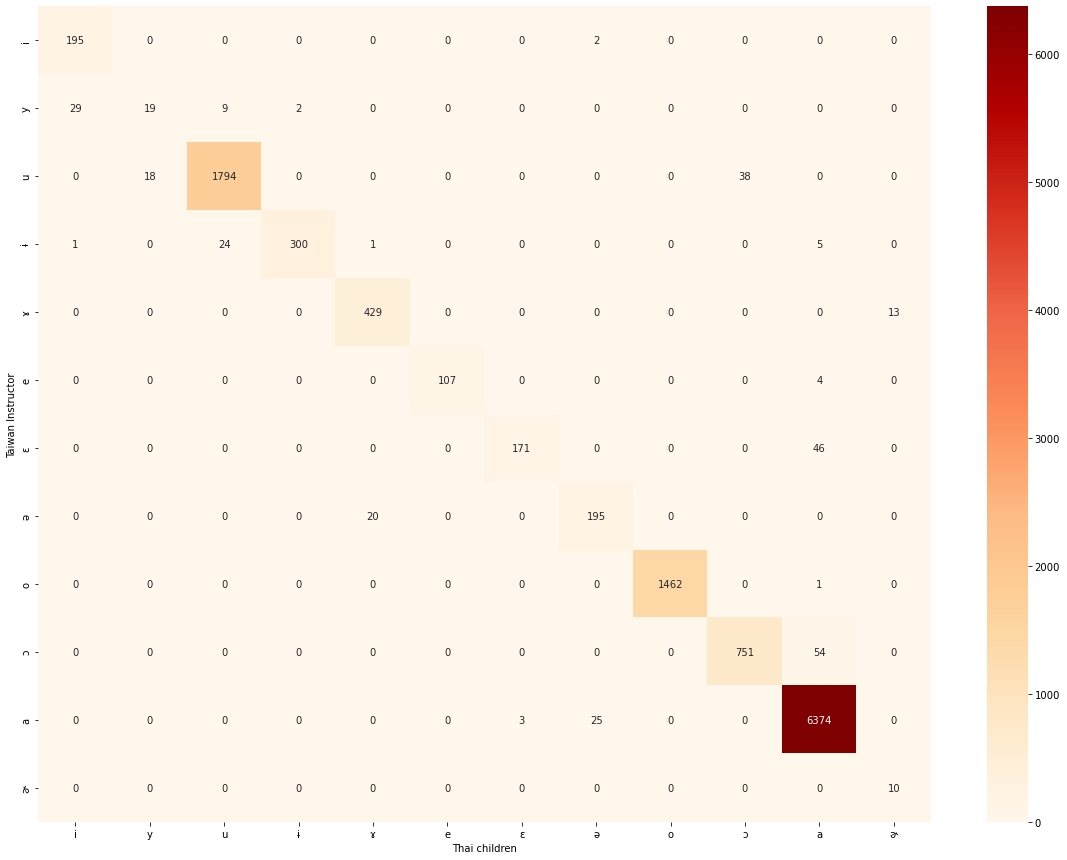

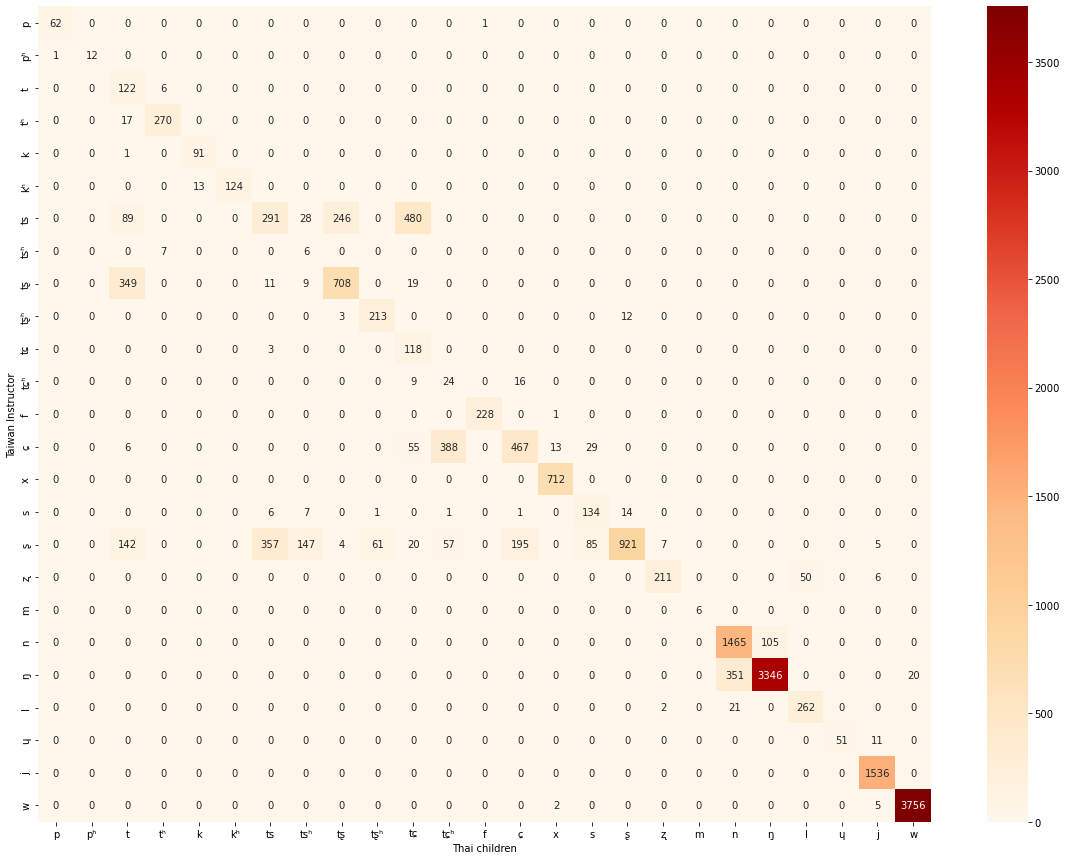

In [34]:
stat_main('data')